In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
df_train=pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv')
df_test=pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26500 non-null  int64  
 1   store_name     26500 non-null  object 
 2   category       26500 non-null  object 
 3   store_address  26500 non-null  object 
 4   latitude       25976 non-null  float64
 5   longitude      25976 non-null  float64
 6   rating_count   26500 non-null  object 
 7   review_time    26500 non-null  object 
 8   review         26500 non-null  object 
 9   rating         26500 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB


In [5]:
df_test.shape

(7000, 9)

In [6]:
numerical_cols=df_train.select_dtypes(include=['int64','float64']).columns
categorical_cols=df_test.select_dtypes(include=['object','bool']).columns

In [7]:
numerical_cols

Index(['id', 'latitude ', 'longitude', 'rating'], dtype='object')

In [8]:
categorical_cols

Index(['store_name', 'category', 'store_address', 'rating_count',
       'review_time', 'review'],
      dtype='object')

In [9]:
df_train.describe()

,id,latitude,longitude,rating
count,26500.000000,25976.000000,25976.000000,26500.000000
mean,13249.500000,34.427152,-90.659226,3.130642
std,7650.035403,5.336112,16.588603,1.615425
min,0.000000,25.790295,-121.995421,1.000000
25%,6624.750000,28.655350,-97.792874,1.000000
50%,13249.500000,33.931261,-81.471414,3.000000
75%,19874.250000,40.727401,-75.399919,5.000000
max,26499.000000,44.981410,-73.459820,5.000000


In [10]:
df_test.describe()

,id,latitude,longitude
count,7000.000000,6864.000000,6864.000000
mean,3499.500000,34.502408,-90.602969
std,2020.870275,5.375098,16.627215
min,0.000000,25.790295,-121.995421
25%,1749.750000,28.655350,-98.634580
50%,3499.500000,34.012219,-81.471414
75%,5249.250000,40.729126,-75.399919
max,6999.000000,44.981410,-73.459820


In [11]:
missing_summary=df_train.isna().sum().sort_values(ascending=False)
missing_summary=missing_summary[missing_summary>0]
missing_df=pd.DataFrame({
    'MISSING COUNT': missing_summary,
    'MISSING PERCENTAGE': (missing_summary/len(df_train)*100).round(2)
})
print('MISSING VALUE SUMMARY :')
display(missing_df)

MISSING VALUE SUMMARY :


,MISSING COUNT,MISSING PERCENTAGE
latitude,524,1.98
longitude,524,1.98


In [12]:
missing_summary=df_test.isna().sum().sort_values(ascending=False)
missing_summary=missing_summary[missing_summary>0]
missing_df=pd.DataFrame({
    'MISSING COUNT': missing_summary,
    'MISSING PERCENTAGE': (missing_summary/len(df_test)*100).round(2)
})
print('MISSING VALUE SUMMARY :')
display(missing_df)

MISSING VALUE SUMMARY :


,MISSING COUNT,MISSING PERCENTAGE
latitude,136,1.94
longitude,136,1.94


In [13]:
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()
num_col=df_train.select_dtypes(include=['int64','float64']).columns
for col in num_col:
    if col in df_train.columns:
        median_val=df_train[col].median()
        df_train[col]=df_train[col].fillna(median_val)
        if col in df_test.columns:
            df_test[col]=df_test[col].fillna(median_val)

In [14]:
df_train['rating_count'] = (
    df_train['rating_count']
    .astype(str)           # convert to string first
    .str.replace(',', '')  # remove commas
    .astype(int)           # convert back to integer
)


In [15]:
df_test['rating_count'] = (
    df_test['rating_count']
    .astype(str)           # convert to string first
    .str.replace(',', '')  # remove commas
    .astype(int)           # convert back to integer
)

In [16]:
missing_summary=df_test.isna().sum().sort_values(ascending=False)
missing_summary=missing_summary[missing_summary>0]
missing_df=pd.DataFrame({
    'MISSING COUNT': missing_summary,
    'MISSING PERCENTAGE': (missing_summary/len(df_test)*100).round(2)
})
print('MISSING VALUE SUMMARY :')
display(missing_df)

MISSING VALUE SUMMARY :


,MISSING COUNT,MISSING PERCENTAGE


In [17]:
print(df_train['review'].iloc[0])

Very nice staff, good place to get all your fast food needs!  Tha k you!  ï¿½ï¿½ï¿


In [18]:
import re
def clean_text(text):
    text=text.encode('ascii','ignore').decode()
    text=re.sub(r'\s+',' ',text)
    return text.strip()
df_train['cleaned_review']=df_train['review'].apply(clean_text)
print(df_train[['review','cleaned_review']].head())

                                              review  \
0  Very nice staff, good place to get all your fa...   
1  I think the morning shift are one of, if not t...   
2  Horrible! Avoid this place at night.  Unsafe. ...   
3  Employees too busy window licking to get any o...   
4  I'm sorry to give only one star. But during ou...   

                                      cleaned_review  
0  Very nice staff, good place to get all your fa...  
1  I think the morning shift are one of, if not t...  
2  Horrible! Avoid this place at night. Unsafe. P...  
3  Employees too busy window licking to get any o...  
4  I'm sorry to give only one star. But during ou...  


In [19]:
df_test["cleaned_review"] = df_test["review"].apply(clean_text)

In [20]:
duplicate_rows=df_train[df_train.duplicated()]
print(f" NUMBER OF DUPLICATES ROWS:{duplicate_rows.shape[0]}")
display(duplicate_rows)

 NUMBER OF DUPLICATES ROWS:0


,id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,cleaned_review


In [21]:
duplicate_columns= df_train.loc[:,df_train.T.duplicated()]

In [22]:
numerical_cols=df_train.select_dtypes(include=['int64','float64']).columns
outlier_summary={}
for col in numerical_cols:
    Q1=df_train[col].quantile(0.25)
    Q3=df_train[col].quantile(0.75)
    IQR = Q3-Q1
    lower_limit=Q1-1.5*IQR
    upper_limit =Q3+1.5*IQR
    outliers = df_train[(df_train[col]< lower_limit)|(df_train[col] > upper_limit)]
    outlier_summary[col]=len(outliers)
outlier_df=pd.DataFrame.from_dict(outlier_summary,orient='index',columns=['Outlier Count'])
outlier_df.sort_values(by='Outlier Count',ascending=False)

,Outlier Count
rating_count,3761
id,0
latitude,0
longitude,0
rating,0


In [23]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)  
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound,upper=upper_bound)
    return df
df_before = df_train.copy()
df_after = df_train.copy()
cols=['rating_count']
for col in cols:
    df_after = cap_outliers(df_after, col)

In [24]:
for col in cols:
    print(f"\nColumn : {col}")
    print(f"Before - Min : {df_before[col].min()},Max : {df_before[col].max()}")
    print(f" After Min : {df_after[col].min()},Max : {df_after[col].max()}")


Column : rating_count
Before - Min : 263,Max : 19682
 After Min : 263,Max : 4916


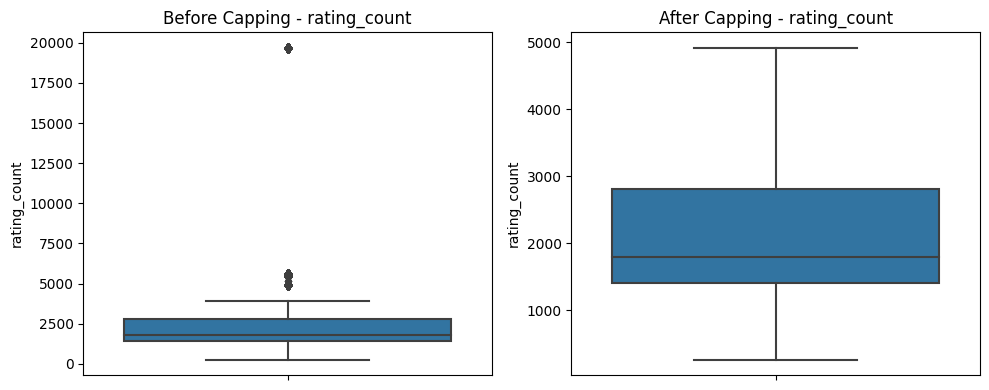

In [25]:
for col in cols:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.boxplot(y=df_before[col])
    plt.title(f"Before Capping - {col}")
    plt.subplot(1,2,2)
    sns.boxplot(y=df_after[col])
    plt.title(f"After Capping - {col}")
    plt.tight_layout()
    plt.show()

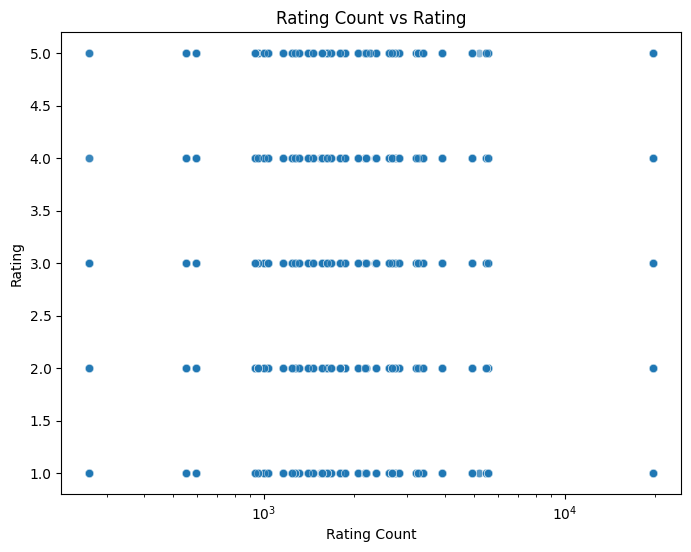

In [26]:
#  Scatter plot: Rating count vs Rating
plt.figure(figsize=(8,6))
sns.scatterplot(x='rating_count', y='rating', data=df_train, alpha=0.5)
plt.title("Rating Count vs Rating")
plt.xlabel("Rating Count")
plt.ylabel("Rating")
plt.xscale("log")  # log scale to handle wide range
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


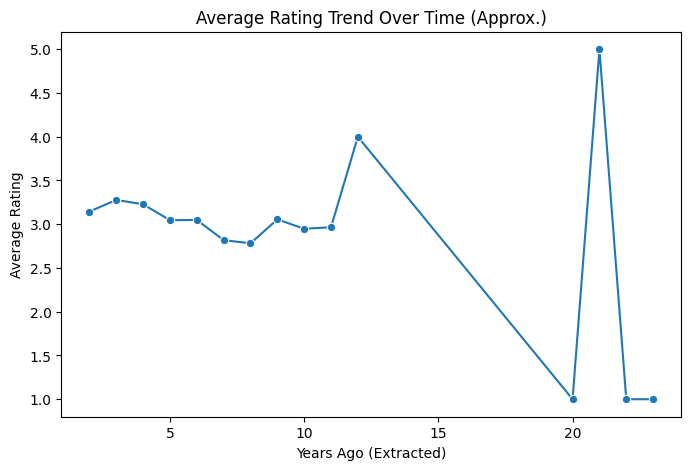

In [27]:
# Line plot: Average rating trend over review_time (simplified year extraction)
df_train['review_year'] = df_train['review_time'].str.extract(r'(\d+)').astype(float)
yearly_trend = df_train.groupby('review_year')['rating'].mean()

plt.figure(figsize=(8,5))
sns.lineplot(x=yearly_trend.index, y=yearly_trend.values, marker="o")
plt.title("Average Rating Trend Over Time (Approx.)")
plt.xlabel("Years Ago (Extracted)")
plt.ylabel("Average Rating")
plt.show()

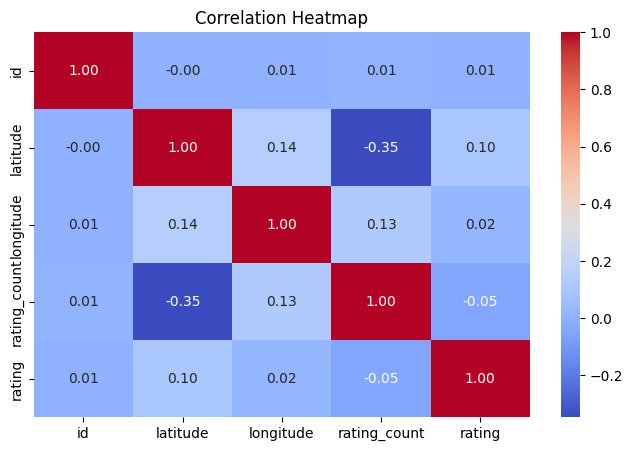

In [28]:
plt.figure(figsize=(8, 5))
sns.heatmap(df_train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

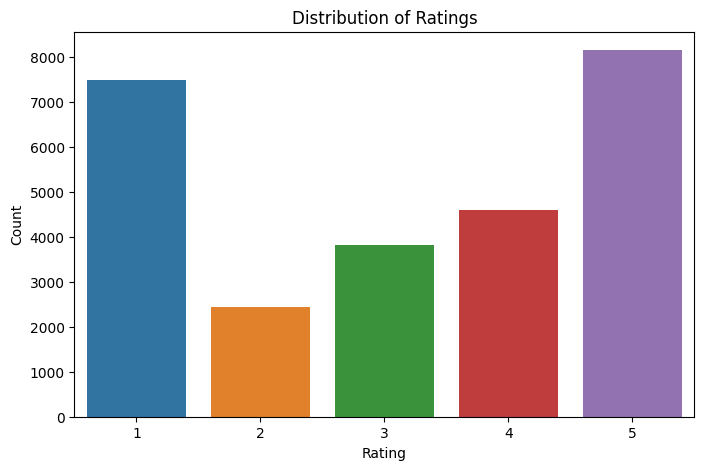

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, x='rating')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

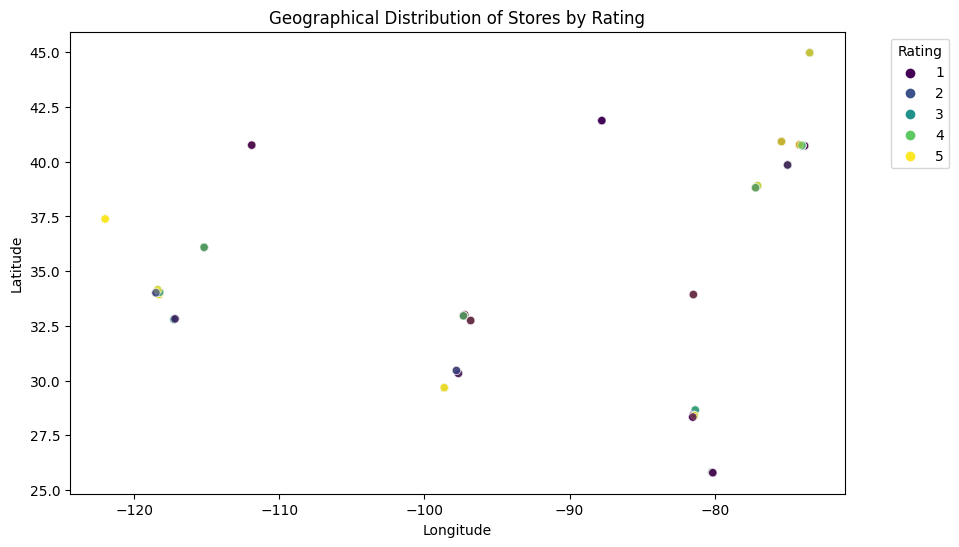

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='longitude', y='latitude', hue='rating', palette='viridis', alpha=0.7)
plt.title("Geographical Distribution of Stores by Rating")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_train[['cleaned_review', 'rating_count', 'latitude', 'longitude', 'store_name', 'category']]
y = df_train['rating']

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'cleaned_review'),
        ('num', StandardScaler(), [ 'latitude', 'longitude']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['store_name', 'category'])
    ]
)

In [34]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

model = LogisticRegression(class_weight='balanced',max_iter=1000)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.610188679245283
              precision    recall  f1-score   support

           1       0.77      0.73      0.75      1498
           2       0.33      0.51      0.40       490
           3       0.50      0.49      0.49       764
           4       0.46      0.51      0.48       918
           5       0.77      0.64      0.70      1630

    accuracy                           0.61      5300
   macro avg       0.57      0.58      0.57      5300
weighted avg       0.64      0.61      0.62      5300


Confusion Matrix:
 [[1101  261   82   33   21]
 [ 140  248   64   23   15]
 [  92  127  374  111   60]
 [  47   70  124  464  213]
 [  55   50  110  368 1047]]


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_processed, y_train)
y_pred = rfc.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6833962264150943

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.92      0.77      1498
           2       0.84      0.29      0.43       490
           3       0.75      0.43      0.55       764
           4       0.67      0.42      0.51       918
           5       0.67      0.86      0.75      1630

    accuracy                           0.68      5300
   macro avg       0.72      0.58      0.60      5300
weighted avg       0.70      0.68      0.66      5300


Confusion Matrix:
 [[1372   13   18   13   82]
 [ 260  141   20   16   53]
 [ 203    8  328   45  180]
 [ 123    3   42  382  368]
 [  89    3   28  111 1399]]


In [37]:
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) 
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_processed, y_train_encoded)
y_pred_encoded = xgb_clf.predict(X_test_processed)
y_pred_original = le.inverse_transform(y_pred_encoded) 
print("Accuracy:", accuracy_score(y_test, y_pred_original))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6533962264150943

Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.92      0.77      1498
           2       0.84      0.29      0.43       490
           3       0.75      0.43      0.55       764
           4       0.67      0.42      0.51       918
           5       0.67      0.86      0.75      1630

    accuracy                           0.68      5300
   macro avg       0.72      0.58      0.60      5300
weighted avg       0.70      0.68      0.66      5300


Confusion Matrix:
 [[1372   13   18   13   82]
 [ 260  141   20   16   53]
 [ 203    8  328   45  180]
 [ 123    3   42  382  368]
 [  89    3   28  111 1399]]


In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_processed, y_train)
y_pred = gb_clf.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6141509433962264

Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.93      0.70      1498
           2       0.70      0.13      0.21       490
           3       0.69      0.33      0.45       764
           4       0.61      0.30      0.40       918
           5       0.66      0.78      0.72      1630

    accuracy                           0.61      5300
   macro avg       0.65      0.49      0.50      5300
weighted avg       0.63      0.61      0.57      5300


Confusion Matrix:
 [[1391   17   17   18   55]
 [ 336   62   26   13   53]
 [ 290    6  252   45  171]
 [ 212    1   51  274  380]
 [ 237    2   18   97 1276]]


In [39]:
from sklearn.svm import LinearSVC
y_train_adj = y_train - 1
y_test_adj = y_test - 1
svc_clf = LinearSVC(random_state=42, max_iter=10000) 
svc_clf.fit(X_train_processed, y_train_adj)
y_pred_adj = svc_clf.predict(X_test_processed)
y_pred = y_pred_adj + 1
y_test_orig = y_test_adj + 1
print("Accuracy:", accuracy_score(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))

Accuracy: 0.6443396226415095

Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.85      0.77      1498
           2       0.47      0.26      0.33       490
           3       0.54      0.43      0.48       764
           4       0.51      0.46      0.48       918
           5       0.70      0.78      0.74      1630

    accuracy                           0.64      5300
   macro avg       0.59      0.55      0.56      5300
weighted avg       0.63      0.64      0.63      5300


Confusion Matrix:
 [[1266   68   68   33   63]
 [ 224  126   59   36   45]
 [ 160   42  330  112  120]
 [  75   18   90  420  315]
 [  61   14   64  218 1273]]


In [40]:
from sklearn.ensemble import AdaBoostClassifier
y_train_adj = y_train - 1
y_test_adj = y_test - 1
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train_processed, y_train_adj)
y_pred_adj = ada_clf.predict(X_test_processed)
y_pred = y_pred_adj + 1
y_test_orig = y_test_adj + 1
print("Accuracy:", accuracy_score(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))

Accuracy: 0.6049056603773585

Classification Report:
               precision    recall  f1-score   support

           1       0.57      0.92      0.70      1498
           2       0.53      0.13      0.21       490
           3       0.64      0.31      0.42       764
           4       0.59      0.30      0.39       918
           5       0.65      0.77      0.71      1630

    accuracy                           0.60      5300
   macro avg       0.60      0.49      0.49      5300
weighted avg       0.60      0.60      0.56      5300


Confusion Matrix:
 [[1372   26   29   14   57]
 [ 325   65   35   23   42]
 [ 274   17  239   51  183]
 [ 200    8   50  272  388]
 [ 243    7   20  102 1258]]


In [41]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
bagging_clf = BaggingClassifier(random_state=42 )  
bagging_clf.fit(X_train_processed, y_train)            
y_pred = bagging_clf.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6637735849056604

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.86      0.77      1498
           2       0.64      0.31      0.42       490
           3       0.67      0.46      0.54       764
           4       0.57      0.47      0.52       918
           5       0.67      0.79      0.73      1630

    accuracy                           0.66      5300
   macro avg       0.65      0.58      0.60      5300
weighted avg       0.66      0.66      0.65      5300


Confusion Matrix:
 [[1289   36   40   38   95]
 [ 221  154   31   29   55]
 [ 157   27  352   66  162]
 [  96   12   53  432  325]
 [  88   11   52  188 1291]]


In [42]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_train_adj = y_train - 1
y_test_adj = y_test - 1

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

xgb_params = {
    'classifier__n_estimators': [100, 200,300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 1],
    'classifier__colsample_bytree': [0.7, 1]
    
}


xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=10, cv=3, n_jobs=-1, verbose=2)
xgb_search.fit(X_train, y_train_adj)


y_pred_adj = xgb_search.predict(X_test)
y_pred = y_pred_adj + 1
y_test_orig = y_test_adj + 1


print("✅ Best Parameters Found:", xgb_search.best_params_)
print("✅ Accuracy on Test Set:", accuracy_score(y_test_orig, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test_orig, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found: {'classifier__subsample': 1, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.7}
✅ Accuracy on Test Set: 0.6732075471698113

📊 Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.89      0.78      1498
           2       0.60      0.26      0.36       490
           3       0.61      0.44      0.51       764
           4       0.62      0.42      0.50       918
           5       0.69      0.86      0.77      1630

    accuracy                           0.67      5300
   macro avg       0.64      0.57      0.58      5300
weighted avg       0.66      0.67      0.65      5300

📉 Confusion Matrix:
 [[1326   41   43   28   60]
 [ 251  125   49   23   42]
 [ 178   24  334   70  158]
 [  87   10   79  384  358]
 [  71    9   40  111 1399]]


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', RandomForestClassifier(random_state=42))
])


rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}


rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


rf_search.fit(X_train, y_train)


y_pred = rf_search.predict(X_test)


print("✅ Best Parameters Found:", rf_search.best_params_)
print("✅ Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__bootstrap': True}
✅ Accuracy on Test Set: 0.689433962264151

📊 Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.94      0.77      1498
           2       0.91      0.28      0.43       490
           3       0.76      0.42      0.55       764
           4       0.73      0.40      0.52       918
           5       0.68      0.87      0.76      1630

    accuracy                           0.69      5300
   macro avg       0.75      0.58      0.61      5300
weighted avg       0.72      0.69      0.66      5300

📉 Confusion Matrix:
 [[1402    6   16    8   66]
 [ 272  139   18   13   48]
 [ 221    5  324   28  186]
 [ 141    1   39  366  371]
 [  93    2   27   

In [44]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', BaggingClassifier(random_state=42))
])

bagging_params = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_samples': [0.5, 0.7, 1.0],
    'classifier__max_features': [0.5, 0.7, 1.0],
    'classifier__bootstrap': [True, False],
    'classifier__estimator': [
        DecisionTreeClassifier(max_depth=3, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        DecisionTreeClassifier(max_depth=None, random_state=42)
    ]
}


bagging_search = RandomizedSearchCV(
    estimator=bagging_pipeline,
    param_distributions=bagging_params,
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


bagging_search.fit(X_train, y_train)


y_pred = bagging_search.predict(X_test)


print("✅ Best Parameters Found:", bagging_search.best_params_)
print("✅ Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Parameters Found: {'classifier__n_estimators': 100, 'classifier__max_samples': 0.5, 'classifier__max_features': 0.5, 'classifier__estimator': DecisionTreeClassifier(random_state=42), 'classifier__bootstrap': False}
✅ Accuracy on Test Set: 0.6862264150943396

📊 Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.91      0.78      1498
           2       0.88      0.29      0.43       490
           3       0.80      0.40      0.53       764
           4       0.71      0.41      0.52       918
           5       0.65      0.89      0.75      1630

    accuracy                           0.69      5300
   macro avg       0.74      0.58      0.60      5300
weighted avg       0.71      0.69      0.66      5300

📉 Confusion Matrix:
 [[1363   10   17   14   94]
 [ 254  141   13   12   70]
 [ 196    7  307   39  215]
 [ 107    2   35  377  397]
 [  82    0   13   86 144

In [45]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

models = {
    'XGBoost': xgb_search,
    'Random Forest': rf_search,
    'Bagging': bagging_search
}

results = []

for name, model in models.items():
    if name == "XGBoost":
        y_pred = model.predict(X_test) + 1   
    else:
        y_pred = model.predict(X_test)       
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='macro'),
        'Best Params': model.best_params_
    })


results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  F1 Score  \
0        XGBoost  0.673208  0.582662   
1  Random Forest  0.689434  0.606269   
2        Bagging  0.686226  0.604054   

                                         Best Params  
0  {'classifier__subsample': 1, 'classifier__n_es...  
1  {'classifier__n_estimators': 200, 'classifier_...  
2  {'classifier__n_estimators': 100, 'classifier_...  


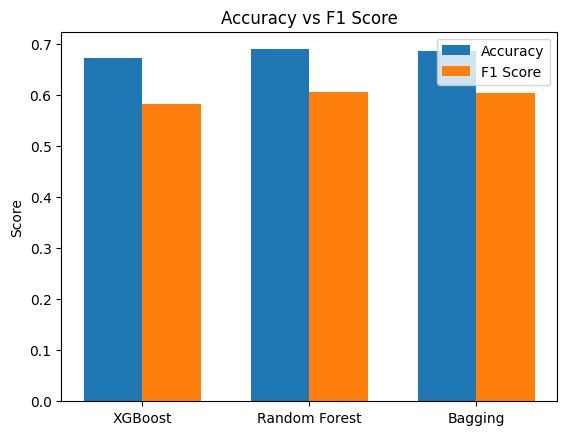

In [46]:
x = results_df['Model']
acc = results_df['Accuracy']
f1 = results_df['F1 Score']

x_pos = np.arange(len(x))
width = 0.35

plt.bar(x_pos - width/2, acc, width, label='Accuracy')
plt.bar(x_pos + width/2, f1, width, label='F1 Score')

plt.xticks(x_pos, x)
plt.ylabel("Score")
plt.title("Accuracy vs F1 Score")
plt.legend()
plt.show()

In [47]:
test_data_p=preprocessor.transform(df_test)
model_only=bagging_search.best_estimator_.named_steps['classifier']
y_test_pred=model_only.predict(test_data_p)

In [48]:
submission = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv')
print(len(y_test_pred),len(submission))

7000 7000


In [49]:
submission['rating'] = y_test_pred
submission.to_csv("submission.csv", index=False)